In [2]:
#for local
import sys
repo_root = "../"
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

In [3]:
%load_ext autoreload
%autoreload 2
import cProfile
import importlib
import numpy as np
import os
import yaml
from generator import MCTS
from language import Language
from node import MolSentenceNode
from utils import add_sep, class_from_package, HELMConverter

config_path = "config/mcts_d_score_replication.yaml"
with open(os.path.join(repo_root, config_path)) as f:
    conf = yaml.safe_load(f)
    
model_class, model_dir, lang_path = (conf.get(k) for k in ("model_class", "model_dir", "lang_path"))
if lang_path is None:
    lang_name = os.path.basename(os.path.normpath(model_dir)) + ".lang"
    lang_path = add_sep(model_dir) + lang_name
lang = Language.load(os.path.join(repo_root, lang_path))
model_class = class_from_package("transition", model_class)
model = model_class(lang=lang, model_dir=os.path.join(repo_root, model_dir))

reward_class, reward_conf = (conf.get(k) for k in ("reward_class", "reward_conf"))
reward_conf = reward_conf or {}
reward_class = class_from_package("reward", reward_class)
reward = reward_class(**reward_conf)

policy_class_path, policy_conf = (conf.get(k) for k in ("policy_class", "policy_conf"))
policy_class = class_from_package("policy", policy_class_path)
policy = policy_class(**policy_conf)

filter_settings = conf.get("filters", [])
filters = []
for s in filter_settings:
    filter_class = class_from_package("filter", s.pop("filter_class"))
    filters.append(filter_class(**s))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<frozen importlib._bootstrap>:241: RuntimeWarning: to-Python converter for class boost::shared_ptr<class RDKit::FilterHierarchyMatcher> already registered; second conversion method ignored.
c:\Users\fsfsf\anaconda3\envs\molgen-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Search is started.
0- time: 0.01, reward: 0.0, node: CC[NH+](Cc1ccc(C[NH2+]C(C)C)cc1)C1CCCC1
1- time: 0.01, reward: 0.3113509395426145, node: CCOC(=O)C[C@H](O)CN1C(=O)[C@H](C)[C@@H]1c1cccc(F)c1
2- time: 0.01, reward: 0.229857892311058, node: Cc1ccc(C(=O)Nc2nc(-c3cnc(C#N)cc3C)n(C)c2C)o1
3- time: 1.14, reward: 0.37316501463580887, node: N#C[C@H](C(=O)NCC(N)=O)c1ccc(F)cc1
4- time: 1.43, reward: 0.26879247823212726, node: Fc1cccc(NCc2ccnc(Cc3ncnn3C(=O)NCc3ccccc3)c2)c1
5- time: 1.43, reward: 0.0, node: Fc1ccc(C[NH2+][C@H](C)c2ccc(F)c([N+](=O)[O-])c2)cc1
6- time: 1.99, reward: 0.3667554435137135, node: [NH3+]CCC[C@H](C)NC(=O)c1ccnc(-c2ccccc2)n1
7- time: 1.99, reward: 0.0, node: [NH3+][C@H](c1ccccc1)C(=O)C1CCCCC1
8- time: 2.44, reward: 0.3099886994667901, node: c1cc(S(=O)(=O)c2ccc(CN3CCOCC3)cc2)sc1
9- time: 2.44, reward: 0.3352181190071604, node: c1ccc(C(=O)Nc2cccc(N3COCC3)c2)nn1
10- time: 2.44, reward: 0.2704044615360873, node: c1ccccc1S(=O)(=O)c1nn(C)c(N2CCCCC2)n1
11- time: 2.91, reward: 0.

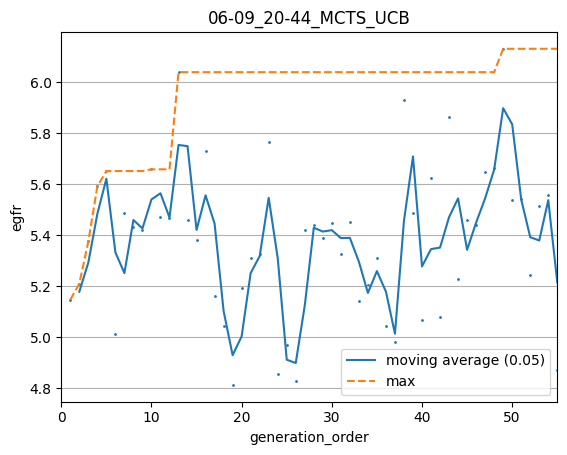

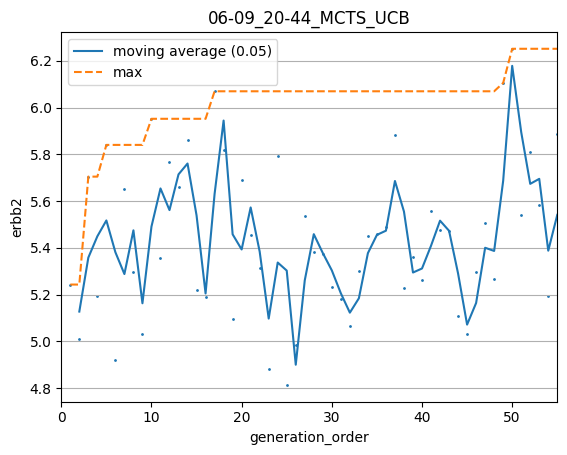

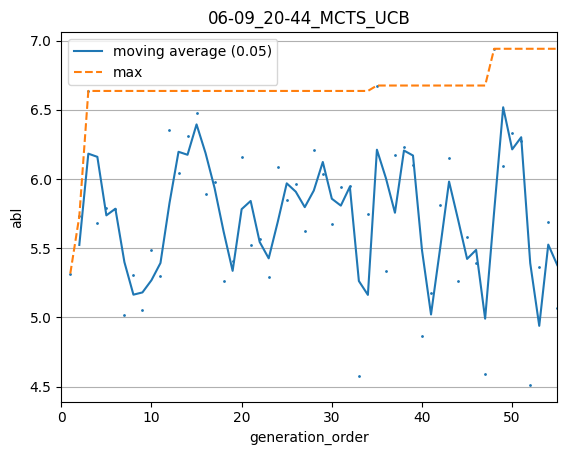

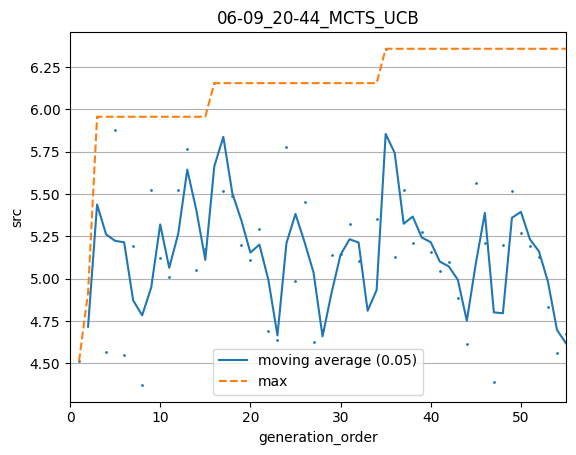

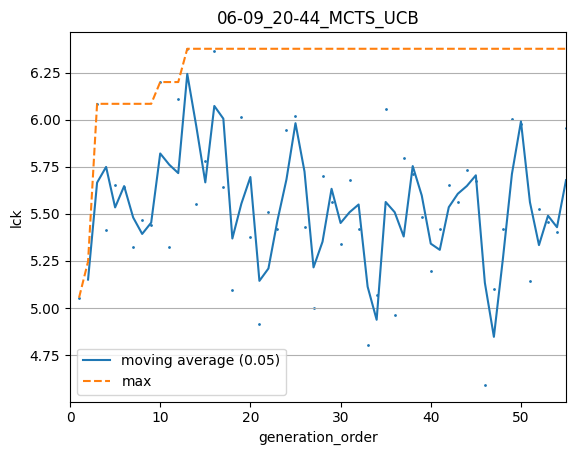

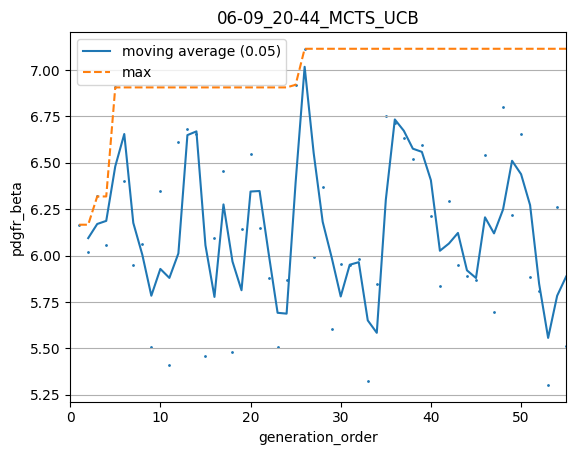

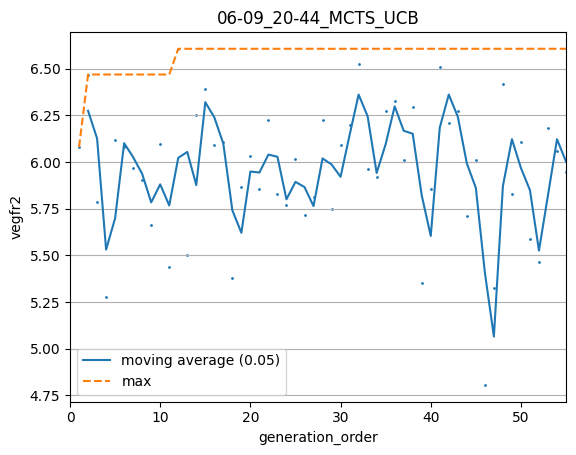

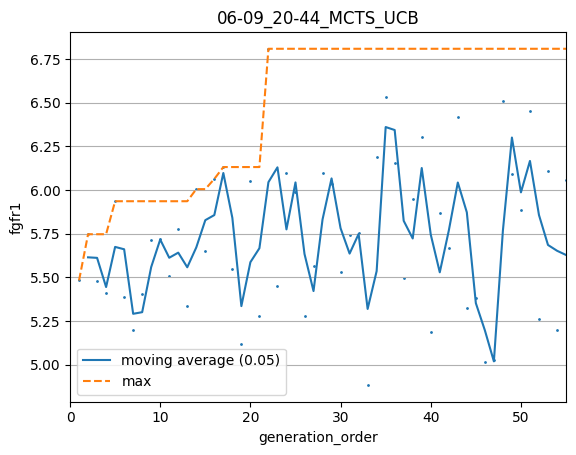

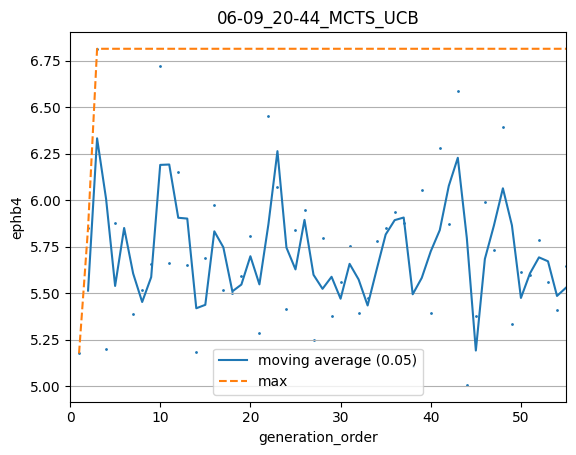

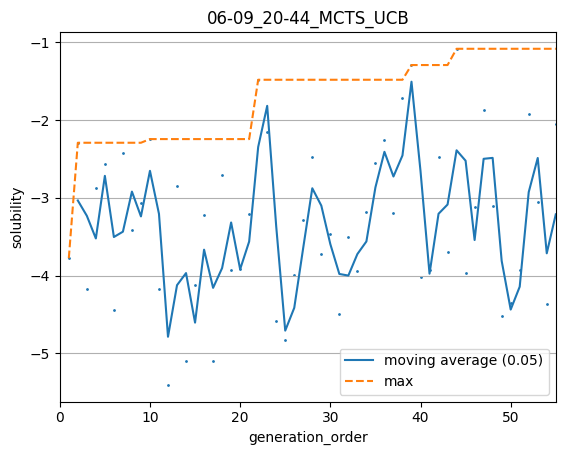

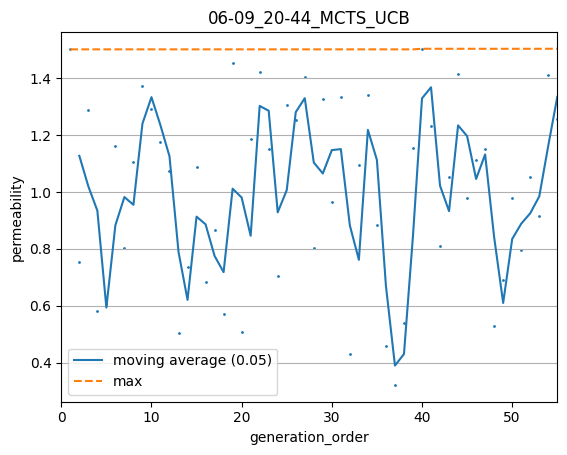

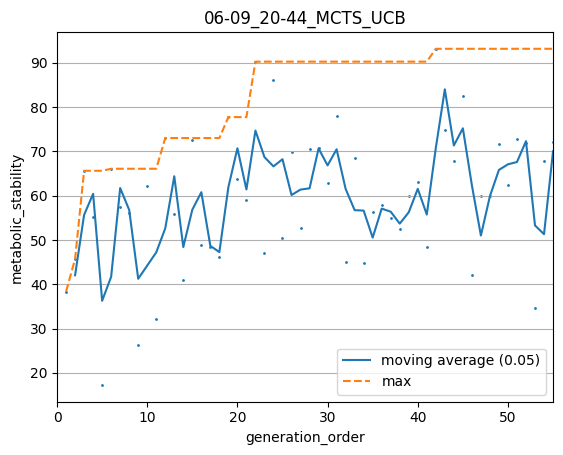

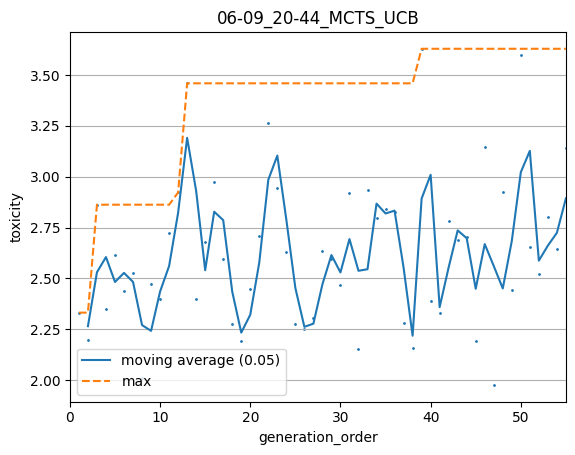

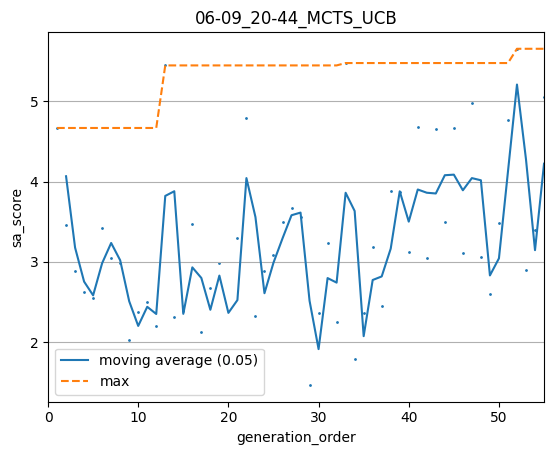

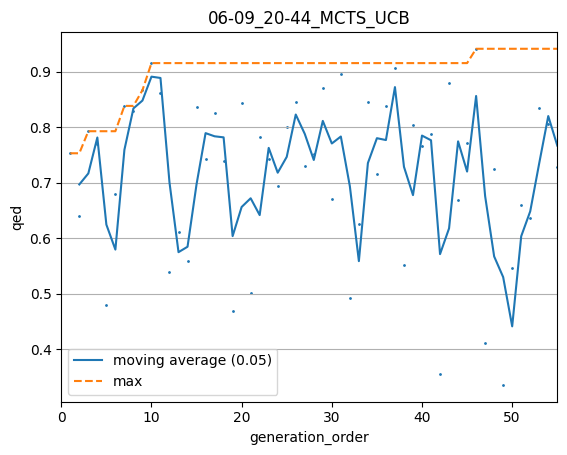

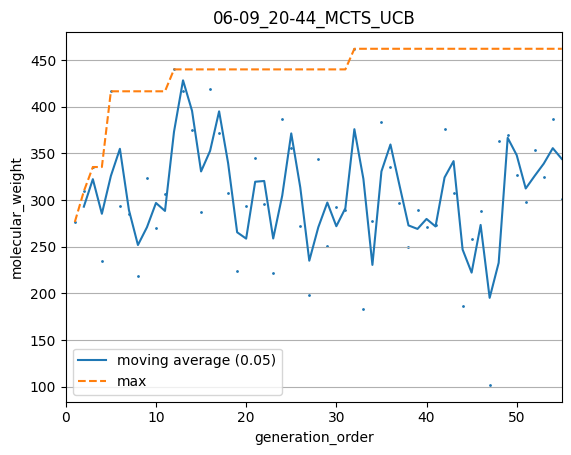

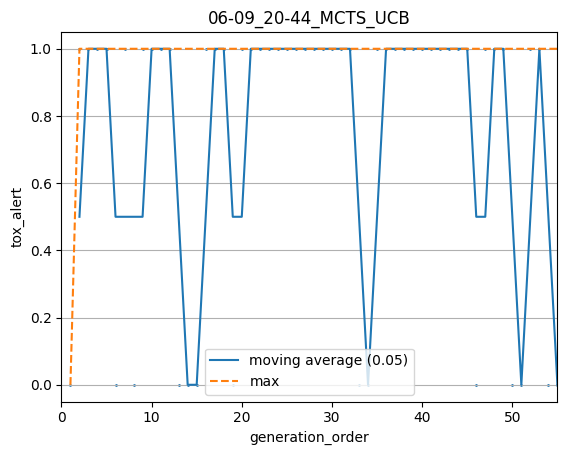

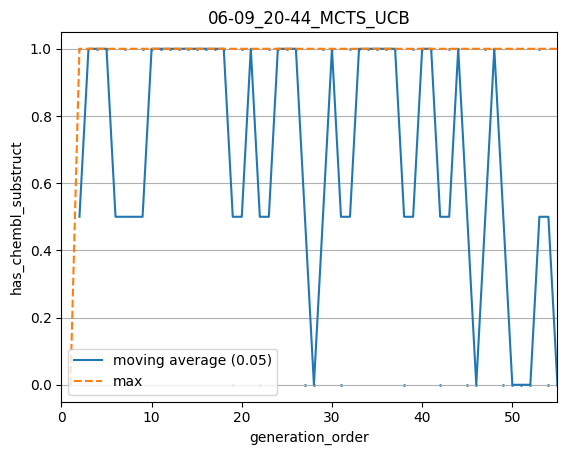

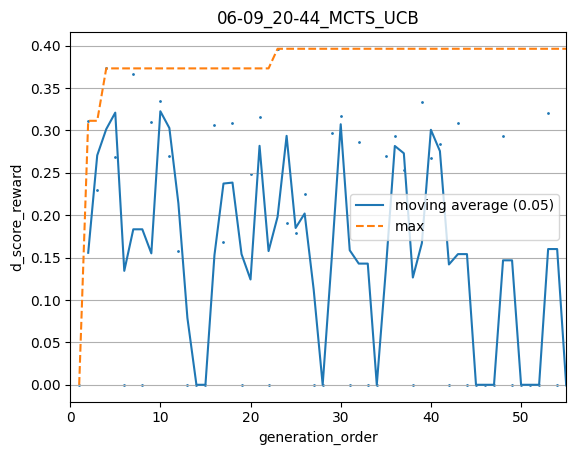

In [4]:
from rdkit import RDLogger
import shutil

RDLogger.DisableLog('rdApp.*') # invalid mols are already logged

root = MolSentenceNode.bos_node(lang) # TODO: change after root node generalization

output_dir, generator_conf, filtered_reward = (conf.get(k) for k in ("output_dir", "generator_conf", "filtered_reward"))
generator = MCTS(root=root, transition=model, reward=reward, policy=policy, filters=filters, filtered_reward=filtered_reward, output_dir=output_dir, **generator_conf)
src = os.path.join(repo_root, config_path)
dst = generator.output_dir() + "setting.yaml"
shutil.copy(src, dst)

time_limit, max_generations = (conf.get(k) for k in ("time_limit", "max_generations"))
generator.generate(time_limit=time_limit, max_generations=max_generations)
# cProfile.run("generator.generate(root=root, **generation_conf)"")

generator.plot_objective_values_and_reward(x_axis = "generation_order")
# generator.plot_objective_values_and_reward(x_axis = "time")

In [12]:
#save mcts
save_path = generator.output_dir() + "test.mcts"
generator.save(save_path)

In [13]:
#load mcts
generator = MCTS.load(save_path, model)